# In this notebook we will present all the results and then choose

\begin{itemize}
    \item Pure data analysis section. where we check curvature i guess. (Anything else?) We could look at a histogram of points in 1D, but how useful would that be?
    \item Section with a table. 
    \item Section 2D visulization. Also 1D visulization. These should be modifiable that i just give it some data and then it's presented. This is because i could just    span some subspace in any dimension and then look how well it interpolates. 
\end{itemize}

In [9]:
import sys, os
import ujson as json
from pathlib import Path 
HOME = "/rds/general/user/dl2119/home/ICLR_Interp" # Path(os.environ["PATH_INTP_FOLDER"])
os.environ["PATH_INTP_FOLDER"] = HOME
HOME = Path(HOME)
sys.path.append(str(HOME))
sys.path.append(str(HOME / "DataGeneration"))
sys.path.append(str(HOME / "ModelGeneration"))
sys.path.append(str(HOME / "ModelComparison"))


import pandas as pd 
import jax.random as jrandom
from scipy.interpolate import RBFInterpolator
import jax.numpy as jnp


from save_load_data import load_fast, get_all_data_configurations
from save_load_model import save_nn
from save_load_comps import load_all_comps
from nn_train import train
from DataAnalysis import curv

import torch
import torchvision
import torch.optim as optim
from torch import Tensor

import torch.nn as nn
from torch.nn import Module

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 

from Functions import get_func
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
    batch_sizes = [16, 64, 256]

    depth_widths = [{'depth': 2, 'width': 8},
                    {'depth': 2, 'width': 64},
                    {'depth': 4, 'width': 8},
                    {'depth': 4, 'width': 64},
                    {'depth': 8, 'width': 8},
                    {'depth': 8, 'width': 64}]


    optimizers = {"Adam": {"lr": [0.001, 0.0001, 1e-5], "momentum": [0.]}, "SGD": {"lr": [1e-2, 1e-3, 1e-4, 1e-5], "momentum": [0., 0.9]}}

    weight_decays = [0, 1e-3, 1]

In [11]:
def normalize(X_data, y_data):
    x_max, x_min = np.max(X_data), np.min(X_data)
    y_max, y_min = np.max(y_data), np.min(y_data)
    X_data = (X_data - (x_max + x_min)/2.) * 5. / ((x_max - x_min)/2.)
    y_data = (y_data - (y_max + y_min)/2.) * 5. / ((y_max - y_min)/2.)
    print(((y_max - y_min)/2.))
    return X_data, y_data

all_data_confs = get_all_data_configurations()
curr_exp_n = 0
for data_conf in all_data_confs:

    func = data_conf["func_name"]
    dim = data_conf["dim"]
    N = data_conf["N"]
    data_gen_method = data_conf["data_gen_method"]

    print("Exp N", curr_exp_n)
    
    if curr_exp_n == 171:
        print(data_conf)
    # if (curr_exp_n % TOTAL_ARRAY) == ARRAY_INDEX:
    #     print("Generating...")
    X_data, y_data = load_fast(func, dim, N, data_gen_method)
    X_data, y_data = normalize(X_data, y_data)

#     generate_nns(X_data, y_data, func, dim, N, data_gen_method)
    # print()
    curr_exp_n += 1

Exp N 0
1.2916757030362729e-76
Exp N 1
1.0526554272105622
Exp N 2
1.3201873606000776
Exp N 3
1.7535053077118476
Exp N 4
2.3024047600978332
Exp N 5
2.3742433448102593
Exp N 6
1.7829384303813374
Exp N 7
2.0686331840227883
Exp N 8
2.1831551828053586
Exp N 9
1.375
Exp N 10
1.6842379628685584
Exp N 11
1.8195255932670427
Exp N 12
2.4654473107368258
Exp N 13
2.5011645719625903
Exp N 14
2.5717922113431286
Exp N 15
0.40729255530748426
Exp N 16
0.37164578483322225
Exp N 17
0.405749503464072
Exp N 18
0.4105218167376578
Exp N 19
0.41052184114143936
Exp N 20
0.4092053207332893
Exp N 21
0.4105205241090979
Exp N 22
0.4105213012225501
Exp N 23
0.40892341695718565
Exp N 24
0.4102918684033862
Exp N 25
0.4081845282384471
Exp N 26
0.40881828365291895
Exp N 27
0.4105218418264103
Exp N 28
0.41052184183853513
Exp N 29
0.40947019830389597
Exp N 30
4.65522807351696e-78
Exp N 31
0.8190298657715642
Exp N 32
0.7390876327697743
Exp N 33
1.6239150685799313
Exp N 34
1.81343546523848
Exp N 35
1.7795031146105214
Exp N

/var/tmp/pbs.6176312.pbs/ipykernel_2791489/693822837.py:5: RuntimeWarning:

invalid value encountered in divide



# Data Visualization

In [4]:
# all data configurations that we have are here
data_confs = get_all_data_configurations()


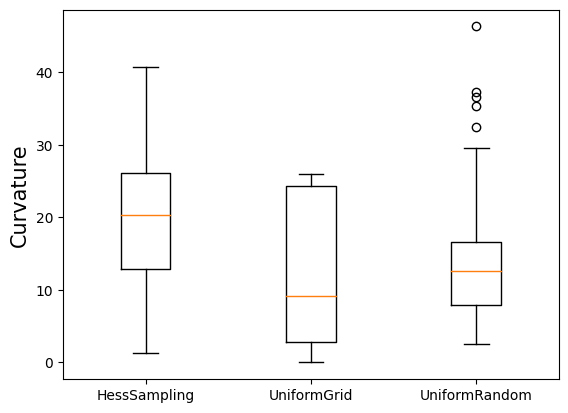

In [6]:
def compute_hess_trace_stat(func, dim, N):
    res = {}
    for data_gen_method in ["HessSampling", "UniformGrid", "UniformRandom"]:
        X_data, y_data = load_fast(func, dim, N, data_gen_method)
        F = get_func(func)
        res[data_gen_method] = np.array(curv(F, X_data))

    fig, ax = plt.subplots()
    ax.boxplot(res.values())
    ax.set_ylabel('Curvature', fontsize=15)
    ax.set_xticklabels(res.keys())
    plt.show()
    
func = "Michi"
dim = 6
N = 100
compute_hess_trace_stat(func, dim, N)

In [16]:
from DataAnalysis import curv    
import plotly.graph_objects as go

def compute_hess_trace_stat(func, dim, N):
    for data_gen_method in ["HessSampling", "UniformGrid", "UniformRandom"]:
        X_data, y_data = load_fast(func, dim, N, data_gen_method)
        F = get_func(func)
        curv_vals = np.array(curv(F, X_data))
        plt.boxplot(curv_vals)
        
    plt.show()
    

    
# For each data, I want to visualize the curvature hist. 
# For each data, I want to visualize 1 and 2D locations. Option toggle to overlay the real data with lower opacity
def hess_trace_visualization(func, dim, N, data_gen_method):
    X_data, y_data = load_fast(func, dim, N, data_gen_method)
    F = get_func(func)
    curv_vals = np.array(curv(F, X_data))
    plt.hist(curv_vals)
    
    plt.show()
    
def loc_vis(func, dim, N, data_gen_method, N_vis):
    assert dim <= 2
    
    X_data, y_data = load_fast(func, dim, N, data_gen_method)
    F = get_func(func)
    
    if dim == 1:
        x_vis = np.linspace(F.bounds[0][0], F.bounds[0][1], N_vis).reshape(-1, 1)
        F_vis = F.f(x_vis)
        hess_trace_vis = curv(F, x_vis)
        
        hess_trace_data = curv(F, X_data)
        
        # F vis
        plt.plot(x_vis, F_vis)
        plt.scatter(X_data, y_data)
        plt.show()
        
        # Hess vis
        plt.plot(x_vis, hess_trace_vis)
        plt.scatter(X_data, hess_trace_data)
        plt.show()
        
    else:
        x_vis = np.linspace(F.bounds[0][0], F.bounds[0][1], N_vis).reshape(-1, 1)
        XY = np.meshgrid(x_vis, x_vis)
        pts = np.array([XY[0].ravel(), XY[1].ravel()]).T
        
        F_vis = F.f(pts)
        hess_trace_vis = curv(F, pts)
        hess_trace_data = curv(F, X_data)
        
        # F vis
        fig = go.Figure(data=[go.Mesh3d(x = pts[:, 0], y = pts[:, 1], z = F_vis, color = 'pink', opacity=0.5),
                                #go.Scatter3d(x=X_data[:, 0], y=X_data[:, 1], z=y_data, mode='markers')
        ])
        fig.update_layout(scene = dict(
                    xaxis_title='x',
                    yaxis_title='y',
                    zaxis_title='Function value'),
                    width=1200)
        fig.show()
        
        # Hess vis
        #fig = go.Figure(data=[go.Mesh3d(x = pts[:, 0], y = pts[:, 1], z = hess_trace_vis, opacity = 0.5),
                                go.Scatter3d(x=X_data[:, 0], y=X_data[:, 1], z=hess_trace_data, mode='markers')
        ])
        fig = go.Figure(data=[go.Mesh3d(x = pts[:, 0], y = pts[:, 1], z = hess_trace_vis, opacity = 0.5),
                                go.Scatter3d(x=X_data[:, 0], y=X_data[:, 1], z=hess_trace_data, mode='markers')
        ])
        fig.update_layout(scene = dict(
                    xaxis_title='x',
                    yaxis_title='y',
                    zaxis_title='Hessian value'),
                    width=1200)
        fig.show()
        
        
        


        
func = "Ackley"
dim = 2
N = 100
data_gen_method = "UniformGrid"
N_vis = 100
loc_vis(func, dim, N, data_gen_method, N_vis)
loc_vis(func, dim, N, "HessSampling", N_vis)




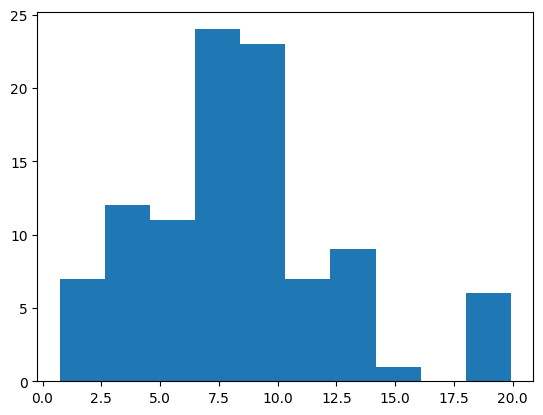

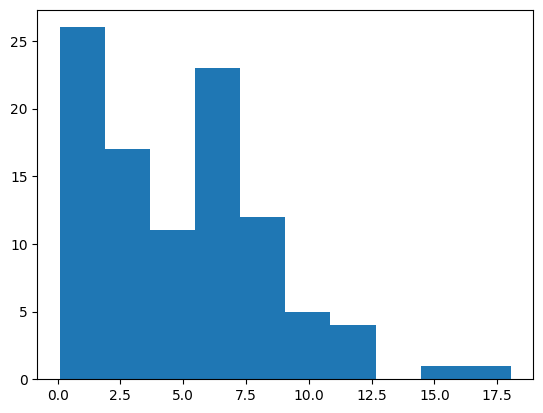

In [51]:
func = "Michi"
dim = 3
N = 100
data_gen_method = "HessSampling"

hess_trace_visualization(func, dim, N, data_gen_method)
hess_trace_visualization(func, dim, N, "UniformRandom")

# Trained Model Visualization

In [ ]:
func = "Schwefel"
dim = 8
N = 100
data_gen_method = "HessSampling"

X_train, y_train = load_fast(func, dim, N, data_gen_method)

def get_rbf_err(func, dim, N, data_gen_method):

    F = get_func(func)

    X_train, y_train = load_fast(func, dim, N, data_gen_method)

    N_test = int(1e3)
    seed_test = 0
    jrandom_key = jrandom.PRNGKey(seed_test)

    X_test = np.array(jrandom.uniform(jrandom_key, minval=F.bounds[:, 0], maxval=F.bounds[:, 1],shape=(N_test, dim)))
    y_test = np.array(F.f(X_test))

    X_train, y_train, X_test, y_test = normalize(X_train, y_train, X_test, y_test)
    
    rbf = RBFInterpolator(X_train, y_train, kernel="thin_plate_spline", neighbors=int(1e3))
    test_out = rbf(X_test)
    test_errs = np.abs(y_test - test_out)
    test_mean_err = np.mean(test_errs**2)
    
    return test_mean_err
    
    

In [ ]:
funcs = ["Schwefel", "Ackley", "Michi", "Rosenbrock"]
dims = [1, 2, 3, 4, 6, 8, 10]
Ns = [1e2, 1e3, 1e4, 1e5] #, 1e6]
data_gen_methods = ["UniformRandom", "UniformGrid", "HessSampling"]
curr_exp_n = 0

N_test = int(1e3)
seed_test = 0
jrandom_key = jrandom.PRNGKey(seed_test)
for func_name in funcs:
    F = get_func(func_name)
    for dim in dims:
        if func_name == "Rosenbrock" and ((dim % 2) == 1):
            continue

        X_test = np.array(jrandom.uniform(jrandom_key, minval=F.bounds[:, 0], maxval=F.bounds[:, 1],shape=(N_test, dim)))
        y_test = np.array(F.f(X_test))
        for N in Ns:
            for data_gen_method in data_gen_methods:
#                 print("Exp num", curr_exp_n)
                if curr_exp_n == 61:
                    print(func_name)
                    print(dim)
                    print(N)
#                     if (curr_exp_n % TOTAL_ARRAY) == ARRAY_INDEX:
#                         X_train, y_train = load_fast(func_name, dim, N, data_gen_method)
#                         X_train, y_train, X_test, y_test = normalize(X_train, y_train, X_test, y_test)

#                         nn_comps = nn_loss(func_name, dim, N, data_gen_method, X_train, y_train, X_test, y_test)
#                         rbf_comps = rbf_loss(X_train, y_train, X_test, y_test)

#                         save_comps(nn_comps, N_test, seed_test, dim, N, func_name, data_gen_method)
#                         save_comps(rbf_comps, N_test, seed_test, dim, N, func_name, data_gen_method)

                curr_exp_n += 1



In [ ]:
def normalize(X_data, y_data, X_test, y_test):
    x_max, x_min = np.max(X_data), np.min(X_data)
    y_max, y_min = np.max(y_data), np.min(y_data)
    X_data = (X_data - (x_max + x_min)/2.) * 5. / ((x_max - x_min)/2.)
    y_data = (y_data - (y_max + y_min)/2.) * 5. / ((y_max - y_min)/2.)

    X_test = (X_test - (x_max + x_min)/2.) * 5. / ((x_max - x_min)/2.)
    y_test = (y_test - (y_max + y_min)/2.) * 5. / ((y_max - y_min)/2.)

    return X_data, y_data, X_test, y_test

In [ ]:
F = get_func(func)
dim = 8

N = 100
X_train = get_uniform_grid(F, N, dim, seed=1)
y_train = F.f(X_train)

In [ ]:
rbf = RBFInterpolator(X_train, y_train, kernel="linear")#, neighbors=int(1e3))


In [ ]:
X_train, y_train = load_fast(func, dim, 100, "UniformGrid")
# get_rbf_err(func, dim, N, "UniformGrid")

In [ ]:
X_train, y_train = load_fast(func, dim, 100, "UniformRandom")
print(y_train[:10])


In [ ]:
func_name = "Schwefel"


df = load_all_comps()

In [ ]:
a = df[df["trainLoss"] < 1.]

In [ ]:
a[(a["func_name"] == "Schwefel") & (a["model"] == "rbf")].tail(50)

In [ ]:
funcs = ["Schwefel", "Ackley", "Michi", "Rosenbrock"]
dims = [1, 2, 3, 4, 6, 8, 10]
Ns = [1e2, 1e3, 1e4, 1e5] #, 1e6]
data_gen_methods = ["UniformRandom", "UniformGrid", "HessSampling"]
extras = [{"model": ["rbf"], "kernel": ["thin", "gaussian", "linear"]}, {"model": ["nn"]}]

In [ ]:
all_res = []
for func in funcs:
    for dim in dims:
        for N in Ns:
            N = int(N)
            for data_gen in data_gen_methods:
                for e in extras:
                    res = {"func_name": func, "dim": dim, "N": N, "data_gen_method": data_gen}
                    fil = (a["func_name"] == func) & (a["dim"] == dim) & (a["N"] == N) \
                                & (a["data_gen_method"] == data_gen)
                    
                    # NN
                    fil_curr = fil
                    res_curr = {k: v for k, v in res.items()}
                    res_curr["model"] = "nn"
                    fil_curr = fil_curr & (a["model"] == "nn")
                    res_curr["testLoss"] = np.min(a[fil_curr]["testLoss"])
                    all_res.append(res_curr)
                    
                    # rbf
                    for kernel in ["thin", "gaussian", "linear"]:
                        fil_curr = fil
                        res_curr = {k: v for k, v in res.items()}
                        res_curr["model"] = "rbf"
                        res_curr["kernel"] = kernel
                        fil_curr = fil_curr & (a["model"] == "rbf") & (a["kernel"] == kernel)
                        res_curr["testLoss"] = np.min(a[fil_curr]["testLoss"])
                        all_res.append(res_curr)
                    
                                            
all_res = pd.DataFrame(all_res)
                        

In [ ]:
all_res[all_res["model"] == "nn"]

In [ ]:
all_res[all_res["model"] == "rbf"]

In [ ]:
all_res = []
for func in funcs:
    for dim in dims:
        for N in Ns:
            N = int(N)
            for data_gen in data_gen_methods:
                res = {"func_name": func, "dim": dim, "N": N, "data_gen_method": data_gen}
                fil = (a["func_name"] == func) & (a["dim"] == dim) & (a["N"] == N) \
                            & (a["data_gen_method"] == data_gen)

                # NN
                fil_curr = fil & (a["model"] == "nn")
                res["testLoss_nn"] = np.min(a[fil_curr]["testLoss"])

                # rbf
                for kernel in ["thin", "gaussian", "linear"]:
                    fil_curr = fil & (a["model"] == "rbf") & (a["kernel"] == kernel)
                    res["testLoss_rbf_{}".format(kernel)] = np.min(a[fil_curr]["testLoss"])

                all_res.append(res)
                    
                                            
all_res = pd.DataFrame(all_res)
                        

In [ ]:
all_res[all_res["func_name"] == "Ackley"].head(50)